In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder 
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import make_scorer, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score
from scipy.sparse import issparse
import xgboost as xgb
import lightgbm as lgb
import time
import warnings
warnings.filterwarnings('ignore')


### Load Data

In [491]:
df = pd.read_csv('C:/Users/asus/Documents/Python/Capstone/New folder/data_bank_marketing_campaign.csv')
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


### Deskripsi Data

In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


### Missiing Values

In [493]:
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

### Duplicate

In [494]:
df.duplicated().sum()

np.int64(8)

In [495]:
# hapus duplikat
df = df.drop_duplicates()

print(f"Jumlah baris setelah drop duplikasi: {df.shape[0]}")

Jumlah baris setelah drop duplikasi: 7805


In [496]:
df.columns

Index(['age', 'job', 'balance', 'housing', 'loan', 'contact', 'month',
       'campaign', 'pdays', 'poutcome', 'deposit'],
      dtype='object')

In [497]:
print("job:", df['job'].unique())
print("housing:", df['housing'].unique())
print("loan:", df['loan'].unique())
print("contact:", df['contact'].unique())
print("month:", df['month'].unique())
print("poutcome:", df['poutcome'].unique())
print("deposit:", df['deposit'].unique())

job: ['admin.' 'self-employed' 'services' 'housemaid' 'technician' 'management'
 'student' 'blue-collar' 'entrepreneur' 'retired' 'unemployed' 'unknown']
housing: ['no' 'yes']
loan: ['no' 'yes']
contact: ['cellular' 'telephone' 'unknown']
month: ['jun' 'apr' 'may' 'nov' 'jan' 'sep' 'feb' 'mar' 'aug' 'jul' 'oct' 'dec']
poutcome: ['unknown' 'other' 'failure' 'success']
deposit: ['yes' 'no']


### Cleaning Kategori (Job)

admin. -> admin

In [498]:
# clean kolom 'job' ganti 'admin.' jadi 'admin'
df['job'] = df['job'].replace('admin.', 'admin')

print(df['job'].unique())

['admin' 'self-employed' 'services' 'housemaid' 'technician' 'management'
 'student' 'blue-collar' 'entrepreneur' 'retired' 'unemployed' 'unknown']


self-employed -> entrepreneur

student -> unemployed

In [499]:
# Group 'self-employed' and 'entrepreneur' together
df['job'] = df['job'].replace({'self-employed': 'entrepreneur'})

df['job'] = df['job'].replace('student', 'unemployed')

# Check the frequency of each category in the 'job' column
job_value_counts = df['job'].value_counts()

print(df['job'].value_counts())


job
management      1789
blue-collar     1343
technician      1289
admin            936
services         658
retired          540
entrepreneur     516
unemployed       496
housemaid        184
unknown           54
Name: count, dtype: int64


Kategori rare (<5%)-> other

In [500]:
# Check the frequency of each category in the 'job' column
job_value_counts = df['job'].value_counts()

# Define the threshold for rare categories (less than 5% of the data)
threshold = 0.05 * len(df)

# Identify rare categories
rare_jobs = job_value_counts[job_value_counts < threshold].index.tolist()

# Group rare categories into 'Other'
df['job'] = df['job'].replace(rare_jobs, 'Other')

# Display the updated distribution of the 'job' column
print(df['job'].value_counts())

job
management      1789
blue-collar     1343
technician      1289
admin            936
services         658
retired          540
entrepreneur     516
unemployed       496
Other            238
Name: count, dtype: int64


### Outlier

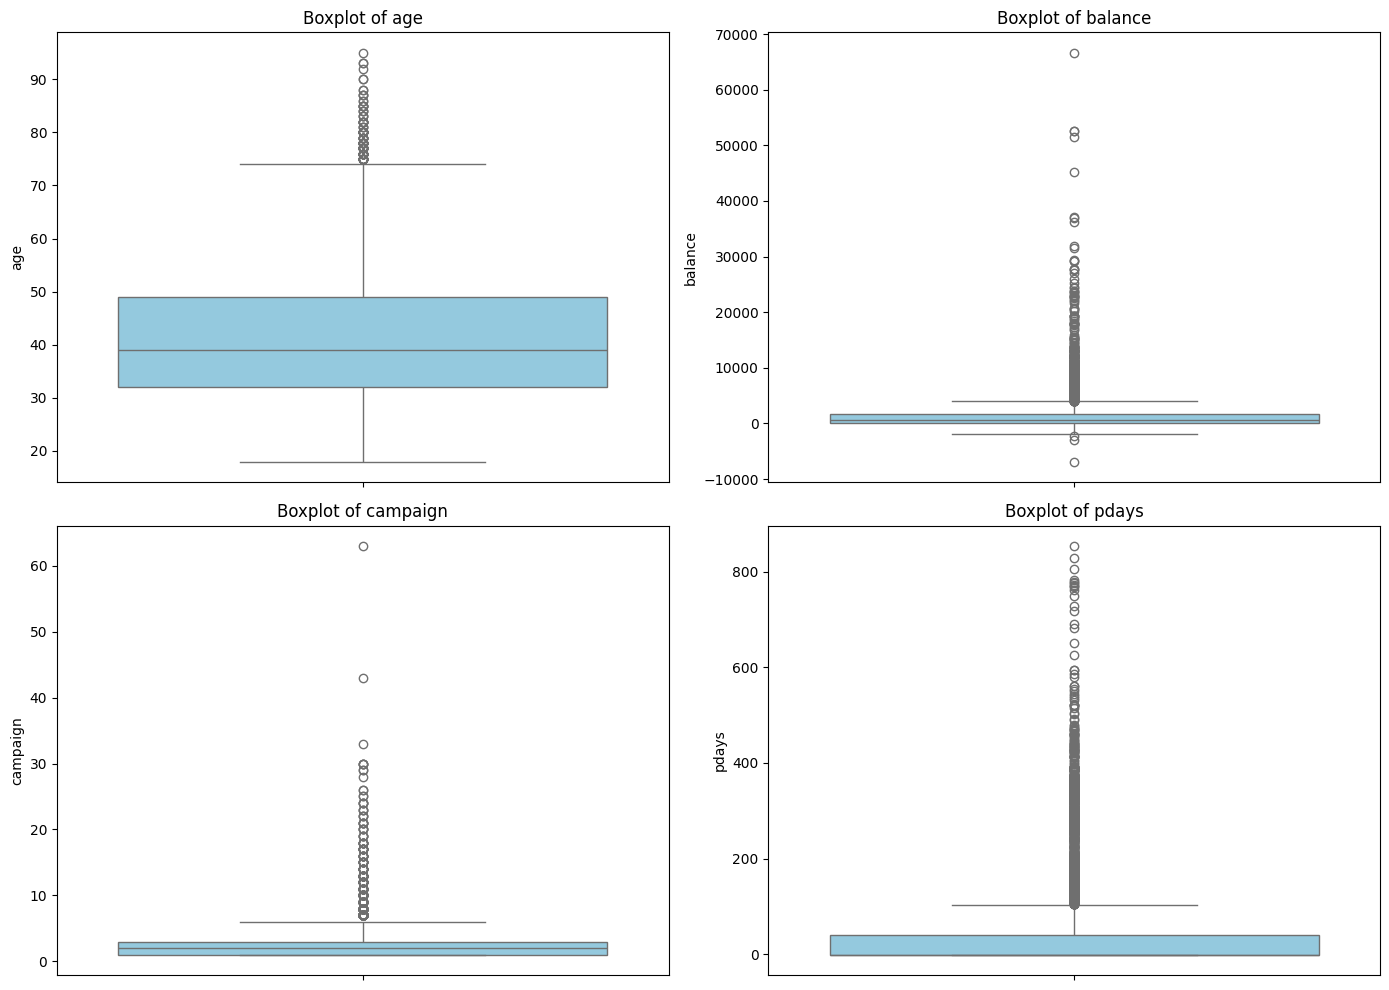

In [501]:
# Daftar fitur numerik yang ingin divisualisasikan
numerical_cols = ['age', 'balance', 'campaign', 'pdays']

# Membuat subplots untuk setiap fitur
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()  # Ubah ke 1D agar bisa loop

# Membuat boxplot untuk tiap fitur
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

### Age
Usia termuda: 18 tahun

Usia tertua: 95 tahun

Usia mayoritas berada di rentang 30–50 tahun

Tidak perlu cleaning khusus untuk age

Outlier tampak mulai dari usia > 80 

### Balance
Total outlier: 736 data
66.653 (tertinggi)
–6.847 (terendah)

Saldo negatif: asumsi bisa jadi mencerminkan autodebet pinjol, biaya administrasi, dll  

solusi outlier: clipping dan binning guna mengganti nilai outlier ekstrem menjadi ambang batas atas dan bawah serta menyederhanakan data menjadi kategori

- Negatif <0

- Rendah (0 – 1.000): indikasi dana pas-pasan

- Sedang (1.001 – 10.000): menengah ke bawah

- Tinggi (>10.000): menengah ke atas

### Campaign

Total outlier: 429 nasabah

63 campaign (tertinggi)

solusi outlier: binning 

-    1x
- 	2–3x	
- 	4–5x	
- 	+5x	

### Pdays 
Total outlier: 1.432

854 (tertinggi)

Solusi outlier: Binning

- tidak pernah: -1

- baru: 0–50

- menengah: 51–105

- lama: 106–300

- sangat lama: >300

Asumsi pdays -1: nasabah baru sehingga belum dihubungi

Asumsi pdays outlier: gabti kontak, nasabah dengan status tidak aktif, dll


## Clipping & Binning Balance

In [502]:
# Hitung batas clipping (1% dan 99%)
Q1 = df['balance'].quantile(0.01)
Q99 = df['balance'].quantile(0.99)

# Clipping: nilai di luar batas akan digantikan dengan Q1 atau Q99
df['balance_clipped'] = df['balance'].clip(lower=Q1, upper=Q99)
# Definisikan batas dan label bin
bins = [-float('inf'), 0, 1000, 10000, float('inf')]
labels = ['negatif', 'rendah', 'sedang', 'tinggi']

# Buat kolom kategorikal berdasarkan binning
df['balance_group'] = pd.cut(df['balance_clipped'], bins=bins, labels=labels)
print(df['balance_group'].value_counts().sort_index())


balance_group
negatif    1018
rendah     3972
sedang     2656
tinggi      159
Name: count, dtype: int64


## Binning Campaign

In [503]:
# Binning untuk kolom 'campaign'
campaign_bins = [0, 1, 3, 5, float('inf')]
campaign_labels = ['1x', '2–3x', '4–5x', '+5x']

df['campaign_group'] = pd.cut(df['campaign'], bins=campaign_bins, labels=campaign_labels, right=True)

print("Distribusi campaign_group:")
print(df['campaign_group'].value_counts().sort_index())


Distribusi campaign_group:
campaign_group
1x      3351
2–3x    3025
4–5x     804
+5x      625
Name: count, dtype: int64


## Binning pdays

In [504]:
# Binning untuk kolom 'pdays'
pdays_bins = [-2, -0.1, 50, 105, 300, float('inf')]  # -2 to capture only -1 exactly
pdays_labels = ['tidak pernah', 'baru', 'menengah', 'lama', 'sangat lama']

df['pdays_group'] = pd.cut(df['pdays'], bins=pdays_bins, labels=pdays_labels)

print("\nDistribusi pdays_group:")
print(df['pdays_group'].value_counts().sort_index())



Distribusi pdays_group:
pdays_group
tidak pernah    5809
baru              53
menengah         526
lama             969
sangat lama      448
Name: count, dtype: int64


In [505]:
df['poutcome'].value_counts()

poutcome
unknown    5811
failure     848
success     761
other       385
Name: count, dtype: int64

>Asumsi: Poutcome yang unknown adalah mayoritas karena berdasarkan pdays bin mayoritas nasabah belum dikontak dalam campaign sebelumnya (pdays= -1)

In [506]:
# Filter DataFrame untuk poutcome == 'unknown'
df_poutcome_unknown = df[df['poutcome'] == 'unknown']

# Dapatkan statistik deskriptif dari 'pdays' untuk kelompok ini
print("Statistik deskriptif 'pdays' untuk poutcome == 'unknown':")
print(df_poutcome_unknown['pdays'].describe())

# Dapatkan statistik deskriptif dari 'pdays' untuk keseluruhan dataset (sebagai perbandingan)
print("\nStatistik deskriptif 'pdays' untuk keseluruhan dataset:")
print(df['pdays'].describe())

Statistik deskriptif 'pdays' untuk poutcome == 'unknown':
count    5811.000000
mean       -0.950439
std         2.798688
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max       188.000000
Name: pdays, dtype: float64

Statistik deskriptif 'pdays' untuk keseluruhan dataset:
count    7805.000000
mean       51.462268
std       108.115084
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        41.000000
max       854.000000
Name: pdays, dtype: float64


Asumsi benar bahwa ketka 'pdays' = -1, maka kemungkinan besar value dari poutcome adalah unknown. Ini mungkin karena 'pdays' = -1 menunjukkan bahwa nasabah yang blm pernah dihubungi sebelumnya, sehingga hasil campaign sebelumnya tidak diketahui

>Asumsi: poutcome other merupakan kategori untuk nasabah yang sudah lama tidak dihubungi (pdays>300) 

In [507]:
# Filter DataFrame untuk poutcome == 'other'
df_poutcome_other = df[df['poutcome'] == 'other']

# Dapatkan statistik deskriptif dari 'pdays' untuk kelompok ini
print("Statistik deskriptif 'pdays' untuk poutcome == 'other':")
print(df_poutcome_other['pdays'].describe())

# Dapatkan statistik deskriptif dari 'pdays' untuk keseluruhan dataset (sebagai perbandingan)
print("\nStatistik deskriptif 'pdays' untuk keseluruhan dataset:")
print(df['pdays'].describe())

Statistik deskriptif 'pdays' untuk poutcome == 'other':
count    385.000000
mean     220.272727
std      127.907807
min        2.000000
25%      115.000000
50%      194.000000
75%      321.000000
max      805.000000
Name: pdays, dtype: float64

Statistik deskriptif 'pdays' untuk keseluruhan dataset:
count    7805.000000
mean       51.462268
std       108.115084
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        41.000000
max       854.000000
Name: pdays, dtype: float64


Asumsi benar bahwa 'pdays'>300, maka kemungkinan besar value dari poutcome adalah other. Ini mungkin karena pdays>300 menunjukkan bahwa nasabah sdh pernah dikontak namun terjadi jauh di masa lalu yg bisa jg mengindikasikan rekening atau kontak ygg inaktif sehingga dikelompokkan scra terpisah

## Fitur Biner Poutcome

In [508]:
# Fitur biner untuk belum dikontak, dan sudah lama tidak dikontak
df['not_previously_contacted'] = (df['pdays'] == -1).astype(int)
df['long_ago_contact'] = (df['pdays'] > 300).astype(int)
# Membuat fitur biner 'previous_success'
df['previous_success'] = (df['poutcome'] == 'success').astype(int)
# Membuat fitur biner 'previous_failure'
df['previous_failure'] = (df['poutcome'] == 'failure').astype(int)

In [509]:
print("Jumlah not_previously_contacted == 1:", df['not_previously_contacted'].value_counts())
print("Jumlah pdays == -1:", len(df[df['pdays'] == -1]))

Jumlah not_previously_contacted == 1: not_previously_contacted
1    5809
0    1996
Name: count, dtype: int64
Jumlah pdays == -1: 5809


In [510]:
print("\nJumlah long_ago_contact == 1:", df['long_ago_contact'].value_counts())
print("Jumlah pdays > 300:", len(df[df['pdays'] > 300]))


Jumlah long_ago_contact == 1: long_ago_contact
0    7357
1     448
Name: count, dtype: int64
Jumlah pdays > 300: 448


In [511]:
print("\nJumlah previous_success == 1:", df['previous_success'].value_counts())
print("Jumlah poutcome == 'success':", len(df[df['poutcome'] == 'success']))


Jumlah previous_success == 1: previous_success
0    7044
1     761
Name: count, dtype: int64
Jumlah poutcome == 'success': 761


In [512]:
print("\nJumlah previous_failure == 1:", df['previous_failure'].value_counts())
print("Jumlah poutcome == 'failure':", len(df[df['poutcome'] == 'failure']))


Jumlah previous_failure == 1: previous_failure
0    6957
1     848
Name: count, dtype: int64
Jumlah poutcome == 'failure': 848


In [513]:
df['deposit'].value_counts(normalize=True)

deposit
no     0.522101
yes    0.477899
Name: proportion, dtype: float64

In [ ]:
# ------------------------------------
# Part 1: Data Preprocessing Function
# ------------------------------------

np.random.seed(42)

def preprocess_data(input_df: pd.DataFrame):

    print("🚀 Starting data preprocessing...")

    # 1. Separate features (X_raw) and target (y_raw)
    X_raw = input_df[[
        'age', 'balance_clipped', 'campaign', 'job', 'housing', 'loan', 'contact',
        'month', 'balance_group', 'campaign_group', 'pdays_group',
        'previous_success', 'previous_failure'
    ]]
    y_raw = input_df['deposit']

    # 2. Encode target variable
    target_label_encoder = LabelEncoder()
    y_encoded = target_label_encoder.fit_transform(y_raw)
    original_target_classes = target_label_encoder.classes_
    print(f"  Encoded target classes: {original_target_classes} mapped to {np.unique(y_encoded)}")

    # 3. Split data into training and testing sets with stratification
    X_train_raw, X_test_raw, y_train_encoded, y_test_encoded = train_test_split(
        X_raw, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print(f"  Data split into training ({X_train_raw.shape[0]} samples) and testing ({X_test_raw.shape[0]} samples).")

    # 4. Define feature types for ColumnTransformer
    categorical_feats = ['job', 'housing', 'loan', 'contact', 'month', 'balance_group', 'campaign_group', 'pdays_group']
    numerical_feats = ['age', 'balance_clipped', 'campaign']
    binary_feats = ['previous_success', 'previous_failure'] 

    # 5. Create preprocessing pipeline using ColumnTransformer
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False)

    feature_preprocessor_pipeline = ColumnTransformer(
        transformers=[
            ('num_transform', numerical_transformer, numerical_feats),
            ('cat_transform', categorical_transformer, categorical_feats),
            ('bin_passthrough', 'passthrough', binary_feats) 
        ],
        remainder='drop', 
        sparse_threshold=0 
    )

    # 6. Fit and transform training data, then transform testing data
    X_train_processed_array = feature_preprocessor_pipeline.fit_transform(X_train_raw)
    X_test_processed_array = feature_preprocessor_pipeline.transform(X_test_raw)
    print("  Numerical and categorical features transformed.")

    # 7. Get feature names after transformation
    processed_numerical_names = feature_preprocessor_pipeline.named_transformers_['num_transform'].get_feature_names_out(numerical_feats)
    processed_categorical_names = feature_preprocessor_pipeline.named_transformers_['cat_transform'].get_feature_names_out(categorical_feats)
    final_feature_names = list(processed_numerical_names) + list(processed_categorical_names) + list(binary_feats) # binary_feats langsung ditambahkan

    # 8. Convert processed arrays back to DataFrames
    X_train_processed_df = pd.DataFrame(X_train_processed_array, columns=final_feature_names, index=X_train_raw.index)
    X_test_processed_df = pd.DataFrame(X_test_processed_array, columns=final_feature_names, index=X_test_raw.index)

    print("\nProcessed data shapes:")
    print(f"  X_train: {X_train_processed_df.shape}")
    print(f"  X_test:  {X_test_processed_df.shape}")
    print(f"  Total features: {len(final_feature_names)}")

    # Print class distribution for the training set
    print("\nClass distribution in training set:")
    unique_classes, counts = np.unique(y_train_encoded, return_counts=True)
    for cls_val, count in zip(unique_classes, counts):
        print(f"  Class '{original_target_classes[cls_val]}': {count} samples ({count/len(y_train_encoded)*100:.1f}%)")

    print("\n✅ Data preprocessing completed.")

    return (X_train_processed_df, X_test_processed_df,
            y_train_encoded, y_test_encoded,
            final_feature_names, original_target_classes,
            feature_preprocessor_pipeline)

In [ ]:
# --------------------------------------------------------
# 2. Threshold Optimization & Business Impact Functions
# --------------------------------------------------------
    
def optimize_threshold(y_true: np.ndarray, y_proba: np.ndarray, metric: str = 'f1'):
    thresholds = np.linspace(0.01, 0.99, 100) 
    results_list = []

    for threshold in thresholds:
        # Convert probabilities to predictions using threshold
        y_pred = (y_proba >= threshold).astype(int)

        # Calculate metrics, handling potential division by zero
        current_accuracy = accuracy_score(y_true, y_pred)
        current_precision = precision_score(y_true, y_pred, zero_division=0)
        current_recall = recall_score(y_true, y_pred, zero_division=0)
        current_f1 = f1_score(y_true, y_pred, zero_division=0)

        results_list.append({
            'threshold': threshold,
            'accuracy': current_accuracy,
            'precision': current_precision,
            'recall': current_recall,
            'f1': current_f1
        })

    threshold_results_df = pd.DataFrame(results_list)

    # Find optimal threshold based on chosen metric
    if metric == 'f1':
        best_idx = threshold_results_df['f1'].idxmax()
    elif metric == 'precision':
        best_idx = threshold_results_df['precision'].idxmax()
    elif metric == 'recall':
        best_idx = threshold_results_df['recall'].idxmax()
    elif metric == 'accuracy':
        best_idx = threshold_results_df['accuracy'].idxmax()
    else:
        raise ValueError("Metric must be one of: 'f1', 'precision', 'recall', 'accuracy'")

    optimal_threshold = threshold_results_df.loc[best_idx, 'threshold']
    best_score_found = threshold_results_df.loc[best_idx, metric]

    return optimal_threshold, best_score_found, threshold_results_df

def plot_threshold_analysis(results_df: pd.DataFrame, optimal_threshold: float):


    plt.figure(figsize=(18, 12)) 

    # Plot 1: All metrics vs threshold
    plt.subplot(2, 2, 1)
    plt.plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision', linewidth=2)
    plt.plot(results_df['threshold'], results_df['recall'], 'g-', label='Recall', linewidth=2)
    plt.plot(results_df['threshold'], results_df['f1'], 'r-', label='F1 Score', linewidth=2)
    plt.plot(results_df['threshold'], results_df['accuracy'], 'orange', label='Accuracy', linewidth=2)

    plt.axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7,
                label=f'Optimal Threshold ({optimal_threshold:.2f})')
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Metrics vs Classification Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Precision-Recall trade-off
    plt.subplot(2, 2, 2)
    plt.plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision', linewidth=2)
    plt.plot(results_df['threshold'], results_df['recall'], 'g-', label='Recall', linewidth=2)
    plt.axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision vs Recall Trade-off')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: F1 Score focus
    plt.subplot(2, 2, 3)
    plt.plot(results_df['threshold'], results_df['f1'], 'r-', linewidth=3)
    plt.axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.grid(True, alpha=0.3)

    # Plot 4: Data table of key thresholds
    plt.subplot(2, 2, 4)
    plt.axis('off') 

    # Show top 5 thresholds by F1 score
    top_results_table = results_df.nlargest(5, 'f1')[['threshold', 'precision', 'recall', 'f1', 'accuracy']]

    # Using matplotlib.table for a more professional-looking table
    table = plt.table(cellText=top_results_table.round(3).values,
                      colLabels=top_results_table.columns,
                      cellLoc = 'center', rowLoc = 'center',
                      loc='center', bbox=[0, 0, 1, 1]) 
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2) 

    plt.title('Top 5 Thresholds by F1 Score', fontsize=12, y=1.05)

    plt.tight_layout()
    plt.show()

def compare_thresholds(y_true: np.ndarray, y_proba: np.ndarray, thresholds: list = [0.3, 0.4, 0.5, 0.6]):
   
    print("\n📊 Threshold Comparison Analysis")
    print("=" * 50)

    comparison_results_list = []
    total_samples = len(y_true)
    total_actual_positive = np.sum(y_true)


    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)

        current_accuracy = accuracy_score(y_true, y_pred)
        current_precision = precision_score(y_true, y_pred, zero_division=0)
        current_recall = recall_score(y_true, y_pred, zero_division=0)
        current_f1 = f1_score(y_true, y_pred, zero_division=0)

        # Count predictions for business context
        total_positive_predictions = np.sum(y_pred)
        targeting_percentage = (total_positive_predictions / total_samples) * 100
        true_positives_captured = int(current_recall * total_actual_positive)

        comparison_results_list.append({
            'threshold': threshold,
            'accuracy': current_accuracy,
            'precision': current_precision,
            'recall': current_recall,
            'f1': current_f1,
            'positive_predictions_count': total_positive_predictions,
            'targeting_percentage': targeting_percentage
        })

        print(f"\n  Threshold: {threshold:.2f}")
        print(f"    F1 Score: {current_f1:.4f}")
        print(f"    Precision: {current_precision:.4f}")
        print(f"    Recall: {current_recall:.4f}")
        print(f"    Accuracy: {current_accuracy:.4f}")
        print(f"    Would target: {total_positive_predictions} customers ({targeting_percentage:.1f}%)")
        print(f"    Would capture: {true_positives_captured} true positives")

    return pd.DataFrame(comparison_results_list)

def business_impact_analysis(y_true: np.ndarray, y_proba: np.ndarray, thresholds: list = [0.3, 0.4, 0.5, 0.6]):
    
    # Business assumptions 
    cost_per_contact = 10     # Cost to contact each customer 
    revenue_per_conversion = 100 # Revenue from each successful conversion 

    print("\n💰 Business Impact Analysis")
    print("=" * 50)
    print(f"  Assumptions:")
    print(f"    Cost per contact: ${cost_per_contact:,.2f}")
    print(f"    Revenue per conversion: ${revenue_per_conversion:,.2f}")
    print()

    business_results_list = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)

        # Calculate confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() 

        total_contacts = tp + fp      # Total customers to contact (predicted positive)
        total_conversions = tp        # Customers who actually convert (true positives)

        # Business metrics
        total_cost = total_contacts * cost_per_contact
        total_revenue = total_conversions * revenue_per_conversion
        net_profit = total_revenue - total_cost
        
        roi_percent = (net_profit / total_cost * 100) if total_cost > 0 else (0 if net_profit >=0 else -np.inf) # Handle negative ROI

        business_results_list.append({
            'threshold': threshold,
            'total_contacts': total_contacts,
            'actual_conversions': total_conversions,
            'total_cost': total_cost,
            'total_revenue': total_revenue,
            'net_profit': net_profit,
            'roi_percent': roi_percent
        })

        print(f"  Threshold {threshold:.2f}:")
        print(f"    Customers to contact: {total_contacts}")
        print(f"    Actual conversions: {total_conversions}")
        print(f"    Total cost: ${total_cost:,.2f}")
        print(f"    Total revenue: ${total_revenue:,.2f}")
        print(f"    Net profit: ${net_profit:,.2f}")
        print(f"    ROI: {roi_percent:.1f}%")
        print()

    return pd.DataFrame(business_results_list)

# Main analysis function
def run_threshold_optimization_pipeline(best_model_eval_results: dict, y_test_labels: np.ndarray):

    y_proba = best_model_eval_results['probabilities'] # Use the probabilities of the best model

    print("🎯 THRESHOLD OPTIMIZATION ANALYSIS")
    print("=" * 60)

    # 1. Find optimal threshold
    optimal_threshold_found, best_f1_score_optimized, all_threshold_metrics_df = \
        optimize_threshold(y_test_labels, y_proba, metric='f1')

    # Get default F1 and Recall from the best model's results (threshold 0.5)
    default_f1_at_05 = best_model_eval_results['f1']
    default_recall_at_05 = best_model_eval_results['recall']

    # Get Recall at optimal threshold from the detailed results_df
    optimal_recall_at_optimized_thresh = all_threshold_metrics_df.loc[
        all_threshold_metrics_df['threshold'] == optimal_threshold_found, 'recall'
    ].values[0]

    print(f"  Current F1 Score (threshold=0.5): {default_f1_at_05:.4f}")
    print(f"  Optimal threshold for F1: {optimal_threshold_found:.2f}")
    print(f"  Best possible F1 Score: {best_f1_score_optimized:.4f}")
    print(f"  Potential F1 improvement: {(best_f1_score_optimized - default_f1_at_05):.4f}")

    # 2. Plot threshold analysis
    plot_threshold_analysis(all_threshold_metrics_df, optimal_threshold_found)

    # 3. Compare specific thresholds (including the optimal one)
    print("\n" + "="*60)
    specific_thresholds_to_compare = [0.3, 0.4, optimal_threshold_found, 0.5, 0.6]
    specific_threshold_comparison_df = compare_thresholds(y_test_labels, y_proba, specific_thresholds_to_compare)

    # 4. Business impact analysis
    business_impact_df = business_impact_analysis(y_test_labels, y_proba, specific_thresholds_to_compare)

    # 5. Recommendations
    print("\n🎯 RECOMMENDATIONS:")
    print("=" * 30)

    if optimal_threshold_found < 0.5:
        print(f"✅ Consider lowering threshold to {optimal_threshold_found:.2f}")
        print(f"   This could improve F1 score from {default_f1_at_05:.4f} to {best_f1_score_optimized:.4f}.")
        print(f"   Trade-off: May increase false positives but capture more true positives (Recall from {default_recall_at_05:.1%} to {optimal_recall_at_optimized_thresh:.1%}).")
    elif optimal_threshold_found > 0.5:
        print(f"✅ Consider raising threshold to {optimal_threshold_found:.2f}")
        print(f"   This could improve F1 score from {default_f1_at_05:.4f} to {best_f1_score_optimized:.4f}.")
        print(f"   Trade-off: Higher precision but may miss some true positives (Recall from {default_recall_at_05:.1%} to {optimal_recall_at_optimized_thresh:.1%}).")
    else:
        print("✅ Current threshold of 0.5 is already optimal, or very close!")
        print(f"   F1 Score is {best_f1_score_optimized:.4f} (Recall: {optimal_recall_at_optimized_thresh:.1%}).")

    print("\n✅ Threshold optimization and business impact analysis completed.")

    return (optimal_threshold_found, best_f1_score_optimized,
            all_threshold_metrics_df, specific_threshold_comparison_df, business_impact_df)

print("Threshold Optimization Tools Ready!")

Threshold Optimization Tools Ready!


In [ ]:
# ----------------------------
# 3. Hyper Parameter Tuning
# ----------------------------

def get_hyperparameter_grids():
   
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    param_grid_xgb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'lambda': [1, 1.5, 2],
        'alpha': [0, 0.1, 0.2]
    }

    param_grid_lgbm = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, -1], # -1 means no limit
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [20, 31, 40],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'subsample': [0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }

    return {
        'Random Forest': param_grid_rf,
        'XGBoost': param_grid_xgb,
        'LightGBM': param_grid_lgbm
    }

def get_base_models():

    return {
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42)
    }

def perform_hyperparameter_tuning(X_train: pd.DataFrame, y_train: np.ndarray,
                                  search_type: str = 'randomized', cv_folds: int = 5, n_iter: int = 50):
   
    print(f"\n⚙️ Performing {search_type} hyperparameter tuning...")
    base_models = get_base_models()
    param_grids = get_hyperparameter_grids()
    tuned_models_dict = {}
    tuning_results_dict = {}

    scorer = make_scorer(f1_score) # Using F1-score as the primary metric for tuning
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for model_name, model_instance in base_models.items():
        print(f"\n  Tuning {model_name}...")
        start_time = time.time()

        if search_type == 'grid':
            search_cv = GridSearchCV(
                estimator=model_instance,
                param_grid=param_grids[model_name],
                scoring=scorer,
                cv=cv,
                n_jobs=-1, # Use all available cores
                verbose=1
            )
        elif search_type == 'randomized':
            search_cv = RandomizedSearchCV(
                estimator=model_instance,
                param_distributions=param_grids[model_name],
                n_iter=n_iter,
                scoring=scorer,
                cv=cv,
                n_jobs=-1,
                verbose=1,
                random_state=42
            )
        else:
            raise ValueError("search_type must be 'grid' or 'randomized'")

        search_cv.fit(X_train, y_train)

        tuned_models_dict[model_name] = search_cv.best_estimator_
        tuning_results_dict[model_name] = {
            'best_score': search_cv.best_score_,
            'best_params': search_cv.best_params_,
            'cv_results': search_cv.cv_results_
        }
        end_time = time.time()
        print(f"  Tuning {model_name} completed in {(end_time - start_time):.2f} seconds.")
        print(f"  Best F1 Score (CV): {search_cv.best_score_:.4f}")
        print(f"  Best Parameters: {search_cv.best_params_}")

    print("\n✅ Hyperparameter tuning complete for all models.")
    return tuned_models_dict, tuning_results_dict

def compare_tuning_results(tuning_results_dict: dict):
    
    print("\n📊 Comparing Cross-Validation Tuning Results:")
    results_list = []
    for model_name, res in tuning_results_dict.items():
        results_list.append({
            'Model': model_name,
            'Best_CV_F1': res['best_score'],
            'Best_Params': res['best_params']
        })

    comparison_df = pd.DataFrame(results_list).sort_values(by='Best_CV_F1', ascending=False)
    print(comparison_df.round(4).to_string(index=False)) # Use to_string(index=False) for cleaner output

    best_model_name_cv = comparison_df.iloc[0]['Model']
    print(f"\n✨ Best model based on Cross-Validation F1-score: {best_model_name_cv}")
    return comparison_df, best_model_name_cv

def analyze_hyperparameter_importance(tuning_results_dict: dict, model_name: str):
    
    print(f"\n🔬 Analyzing Hyperparameter Importance for {model_name}:")
    cv_results = tuning_results_dict.get(model_name, {}).get('cv_results_')

    if cv_results and 'params' in cv_results and 'mean_test_score' in cv_results:
        # Create a DataFrame from CV results
        results_df = pd.DataFrame(cv_results)
        # Identify parameter columns
        param_cols = [col for col in results_df.columns if col.startswith('param_')]

        if param_cols:
            # Calculate correlation between parameters and mean test score (F1)
            param_values_df = results_df[param_cols].apply(pd.to_numeric, errors='coerce')
            correlations = param_values_df.corrwith(results_df['mean_test_score']).dropna().sort_values(ascending=False)

            if not correlations.empty:
                print("  Correlation of hyperparameters with Mean Test F1 Score:")
                print(correlations.to_string())
            else:
                print("  No numerical parameters found for correlation analysis or no variance.")

        else:
            print("  No hyperparameter columns found in CV results for analysis.")
    else:
        print(f"  CV results not available or in unexpected format for {model_name} to analyze hyperparameter importance.")

# Main pipeline function
def run_hyperparameter_tuning_pipeline(X_train_df: pd.DataFrame, X_test_df: pd.DataFrame,
                                       y_train_labels: np.ndarray, y_test_labels: np.ndarray,
                                       feature_names_list: list, target_classes_array: np.ndarray):


    print("\n🚀 STARTING HYPERPARAMETER TUNING PIPELINE")
    print("=" * 60)

    # Step 1: Perform hyperparameter tuning
    tuned_models_dict, tuning_results_dict = perform_hyperparameter_tuning(
        X_train_df, y_train_labels,
        search_type='randomized',
        cv_folds=5,
        n_iter=50
    )

    if not tuned_models_dict:
        print("❌ No models were successfully tuned! Returning None for all outputs.")
        # Return None for all expected outputs to avoid errors in subsequent cells
        return None, None, None, None, None, None

    # Step 2: Compare tuning results (based on CV F1-score)
    cv_comparison_df, best_model_name_cv = compare_tuning_results(tuning_results_dict)

    # Step 3: Evaluate tuned models on test set
    print("\n" + "=" * 60)
    print("📈 EVALUATING TUNED MODELS ON TEST SET")
    print("=" * 60)

    test_results_dict = {}

    for model_name_eval, model_obj_eval in tuned_models_dict.items():
        print(f"\n  Evaluating {model_name_eval} on test set...")
        y_pred_test = model_obj_eval.predict(X_test_df)
        y_proba_test = model_obj_eval.predict_proba(X_test_df)[:, 1]

        # Calculate metrics
        current_accuracy = accuracy_score(y_test_labels, y_pred_test)
        current_precision = precision_score(y_test_labels, y_pred_test, zero_division=0)
        current_recall = recall_score(y_test_labels, y_pred_test, zero_division=0)
        current_f1 = f1_score(y_test_labels, y_pred_test, zero_division=0)
        current_roc_auc = roc_auc_score(y_test_labels, y_proba_test)

        test_results_dict[model_name_eval] = {
            'model': model_obj_eval,
            'model_name': model_name_eval,
            'accuracy': current_accuracy,
            'precision': current_precision,
            'recall': current_recall,
            'f1': current_f1,
            'roc_auc': current_roc_auc,
            'predictions': y_pred_test,
            'probabilities': y_proba_test,
            'cv_f1_score': tuning_results_dict[model_name_eval]['best_score'] # Get CV F1 for comparison
        }

        print(f"  {model_name_eval} Test Performance:")
        print(f"    Accuracy:  {current_accuracy:.4f}")
        print(f"    Precision: {current_precision:.4f}")
        print(f"    Recall:    {current_recall:.4f}")
        print(f"    F1 Score:  {current_f1:.4f}")
        print(f"    ROC-AUC:   {current_roc_auc:.4f}")
        print(f"    CV F1 (from tuning): {tuning_results_dict[model_name_eval]['best_score']:.4f}")

    # Step 4: Final comparison of models based on Test Set performance
    print("\n" + "=" * 60)
    print("🏆 FINAL MODEL COMPARISON (Based on Test Set Performance)")
    print("=" * 60)

    final_comparison_df = pd.DataFrame({
        'Model': [name for name in test_results_dict.keys()],
        'Test_F1_Score': [test_results_dict[name]['f1'] for name in test_results_dict.keys()],
        'CV_F1_Score': [test_results_dict[name]['cv_f1_score'] for name in test_results_dict.keys()],
        'Test_Accuracy': [test_results_dict[name]['accuracy'] for name in test_results_dict.keys()],
        'Test_Precision': [test_results_dict[name]['precision'] for name in test_results_dict.keys()],
        'Test_Recall': [test_results_dict[name]['recall'] for name in test_results_dict.keys()],
        'ROC_AUC': [test_results_dict[name]['roc_auc'] for name in test_results_dict.keys()]
    }).sort_values('Test_F1_Score', ascending=False)

    print(final_comparison_df.round(4).to_string(index=False))

    best_model_name_on_test = final_comparison_df.iloc[0]['Model']
    best_model_object = test_results_dict[best_model_name_on_test]['model']

    print(f"\n🥇 Best Model on Test Set: {best_model_name_on_test}")
    print(f"  Test F1 Score: {final_comparison_df.iloc[0]['Test_F1_Score']:.4f}")

    # Step 5: Analyze best model's hyperparameter importance
    analyze_hyperparameter_importance(tuning_results_dict, best_model_name_on_test)

    print("\n✅ Hyperparameter tuning pipeline completed successfully.")

    # Return values for the next cell
    return (test_results_dict, best_model_object, best_model_name_on_test,
            feature_names_list, target_classes_array, y_test_labels)

🚀 STARTING MACHINE LEARNING PIPELINE EXECUTION

Step 1: Preprocessing raw data...
🚀 Starting data preprocessing...
  Encoded target classes: ['no' 'yes'] mapped to [0 1]
  Data split into training (6244 samples) and testing (1561 samples).
  Numerical and categorical features transformed.

Processed data shapes:
  X_train: (6244, 44)
  X_test:  (1561, 44)
  Total features: 44

Class distribution in training set:
  Class 'no': 3260 samples (52.2%)
  Class 'yes': 2984 samples (47.8%)

✅ Data preprocessing completed.

Step 2: Running hyperparameter tuning and model evaluation pipeline...

🚀 STARTING HYPERPARAMETER TUNING PIPELINE

⚙️ Performing randomized hyperparameter tuning...

  Tuning Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Tuning Random Forest completed in 162.21 seconds.
  Best F1 Score (CV): 0.6828
  Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}

  Tuning XGBoost

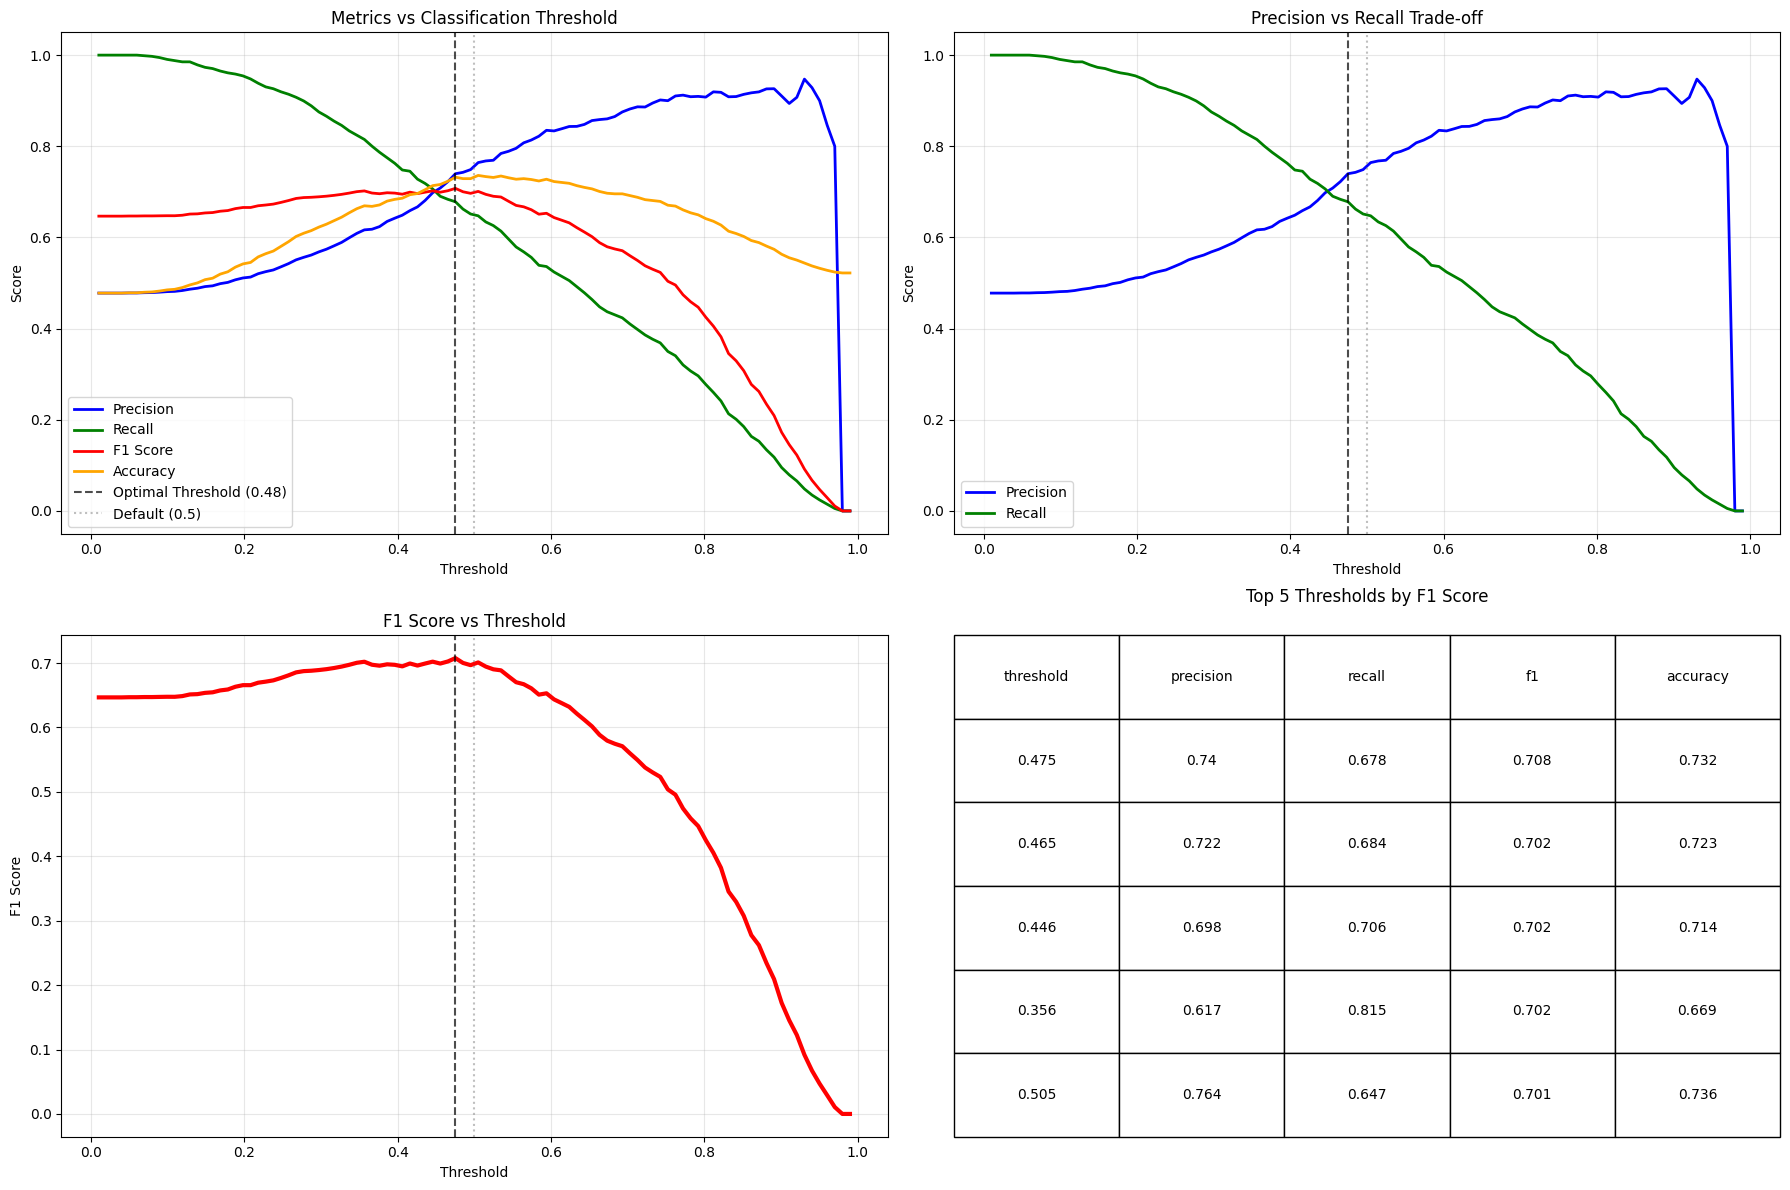



📊 Threshold Comparison Analysis

  Threshold: 0.30
    F1 Score: 0.6896
    Precision: 0.5694
    Recall: 0.8740
    Accuracy: 0.6240
    Would target: 1145 customers (73.4%)
    Would capture: 652 true positives

  Threshold: 0.40
    F1 Score: 0.6955
    Precision: 0.6449
    Recall: 0.7547
    Accuracy: 0.6842
    Would target: 873 customers (55.9%)
    Would capture: 563 true positives

  Threshold: 0.48
    F1 Score: 0.7077
    Precision: 0.7398
    Recall: 0.6783
    Accuracy: 0.7322
    Would target: 684 customers (43.8%)
    Would capture: 506 true positives

  Threshold: 0.50
    F1 Score: 0.6994
    Precision: 0.7566
    Recall: 0.6501
    Accuracy: 0.7329
    Would target: 641 customers (41.1%)
    Would capture: 485 true positives

  Threshold: 0.60
    F1 Score: 0.6459
    Precision: 0.8344
    Recall: 0.5268
    Accuracy: 0.7239
    Would target: 471 customers (30.2%)
    Would capture: 393 true positives

💰 Business Impact Analysis
  Assumptions:
    Cost per contact: 

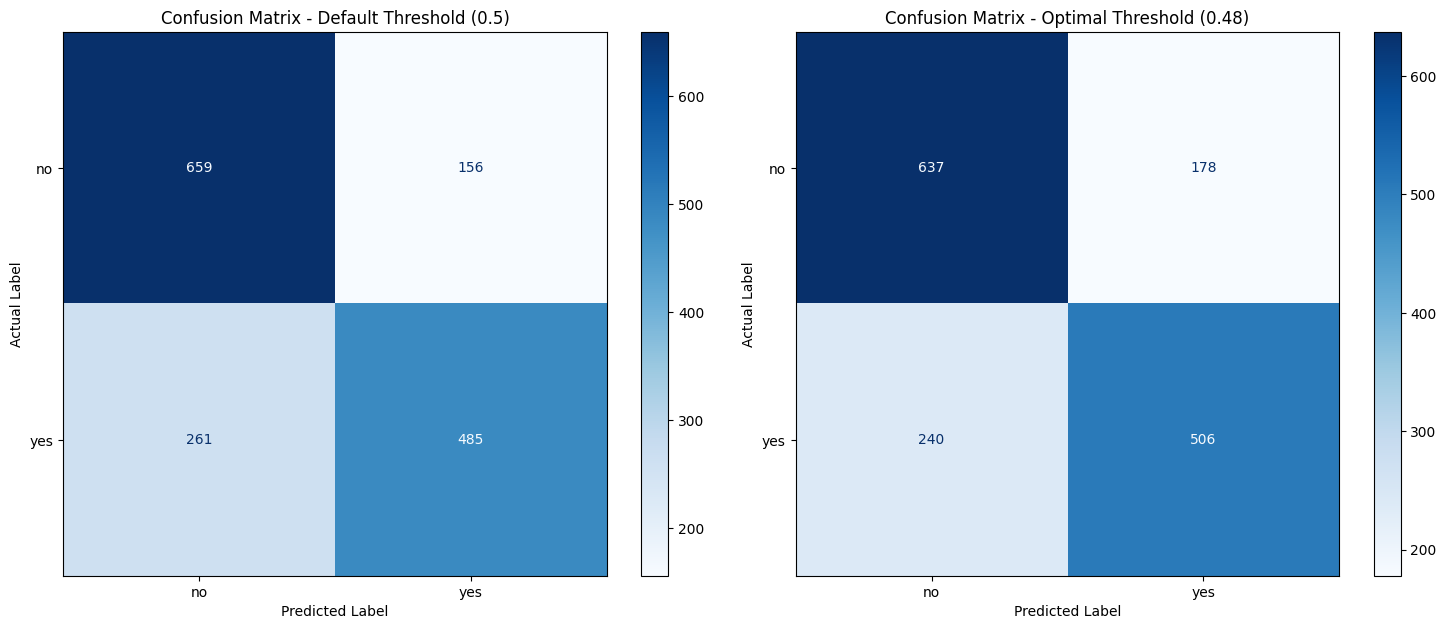


===== Feature Importance Analysis for Random Forest =====



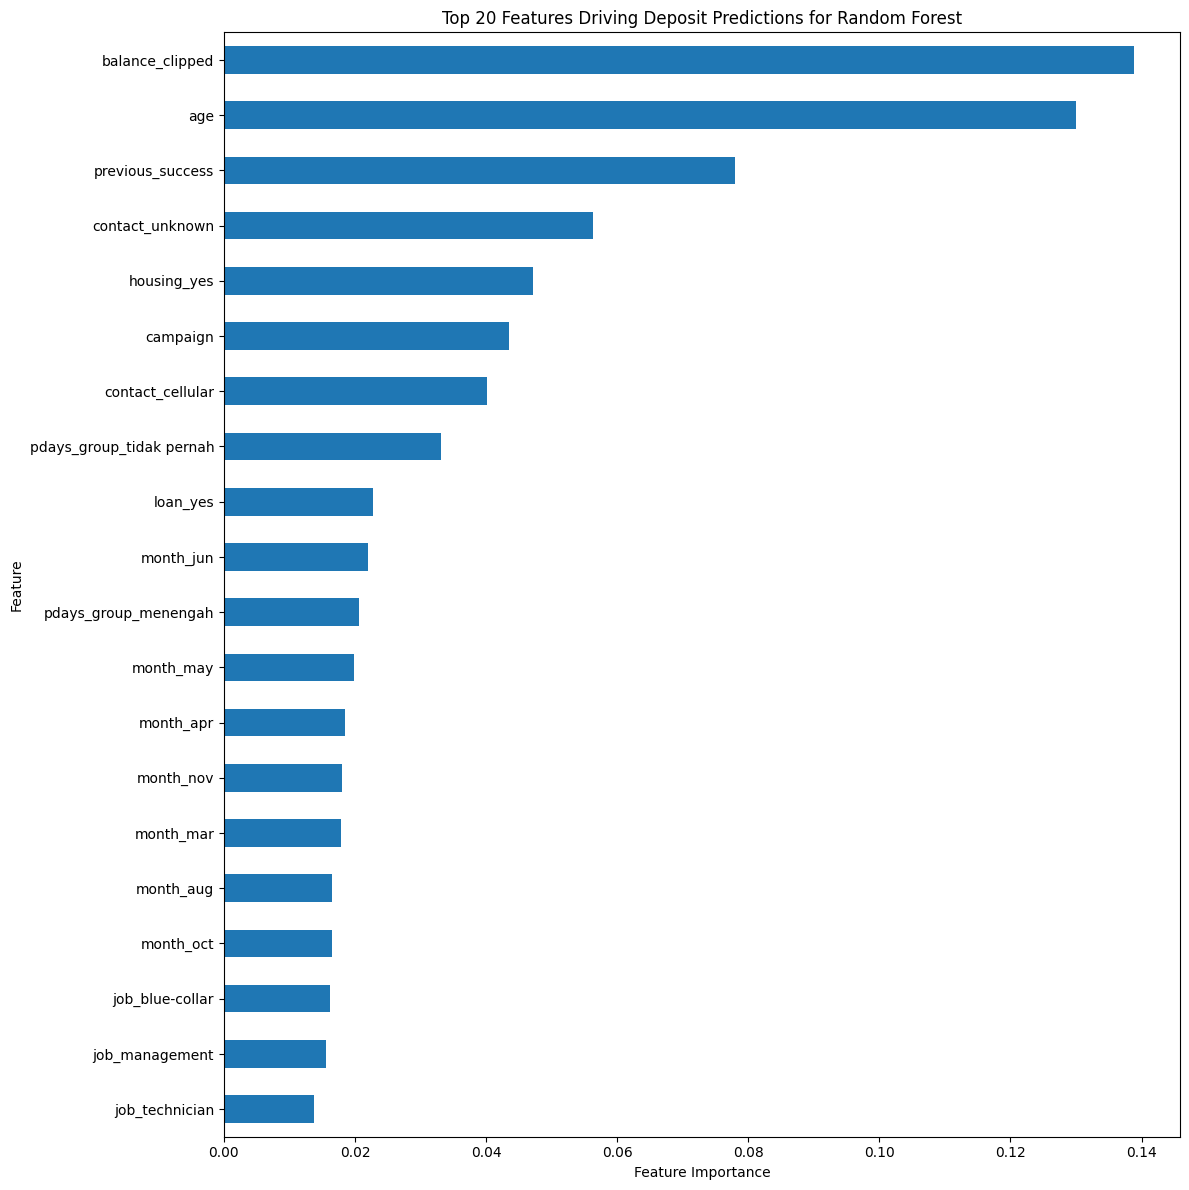


===== Business Impact Comparison Table =====

 threshold  total_contacts  actual_conversions  total_cost  total_revenue  net_profit  roi_percent
      0.30            1145                 652       11450          65200       53750       469.43
      0.40             873                 563        8730          56300       47570       544.90
      0.48             684                 506        6840          50600       43760       639.77
      0.50             641                 485        6410          48500       42090       656.63
      0.60             471                 393        4710          39300       34590       734.39

===== Final Recommendations Summary =====

Based on the analysis, the recommended optimal classification threshold for 'Random Forest' is 0.48.
This threshold aims to maximize the F1-score, providing a good balance between Precision and Recall for identifying potential depositors.

Key takeaways:
- The model, with the optimized threshold, is expected to ge

In [ ]:
# ----------------------------# ------------------------
# Main Execution, Evaluation, and Final Recommendations
# ----------------------------# ------------------------

print("🚀 STARTING MACHINE LEARNING PIPELINE EXECUTION")
print("=" * 60)

# 1. Preprocess data
print("\nStep 1: Preprocessing raw data...")
X_train_processed_df, X_test_processed_df, y_train_encoded, y_test_encoded, \
feature_names_processed, target_classes_original, data_preprocessor_fitted = preprocess_data(df)

# 2. Run hyperparameter tuning pipeline
print("\nStep 2: Running hyperparameter tuning and model evaluation pipeline...")
all_model_test_results, best_model_fitted_object, best_model_name_on_test, \
feature_names_for_next_steps, target_classes_for_next_steps, y_test_for_next_steps = \
    run_hyperparameter_tuning_pipeline(
        X_train_processed_df,
        X_test_processed_df,
        y_train_encoded,
        y_test_encoded, 
        feature_names_processed,
        target_classes_original
    )

# Memastikan hasil dari pipeline tersedia sebelum melanjutkan
if all_model_test_results is None or best_model_fitted_object is None:
    print("\n❌ Hyperparameter tuning pipeline failed or returned no best model. Aborting further steps.")

else:
    print("\nStep 3: Running threshold optimization and business impact analysis...")
    # Mendapatkan hasil evaluasi spesifik untuk model terbaik
    best_model_results_for_threshold_opt = all_model_test_results[best_model_name_on_test]

    # 3. Run threshold optimization pipeline
    optimal_threshold_found, best_f1_score_optimized, \
    all_threshold_metrics_df, specific_threshold_comparison_df, business_impact_df = \
        run_threshold_optimization_pipeline(best_model_results_for_threshold_opt, y_test_for_next_steps)

    print(f"\n✅ Main Pipeline Execution Completed Successfully!")
    print(f"📊 Best model determined through hyperparameter tuning: {best_model_name_on_test}")
    print(f"🎯 Optimal threshold for F1-score: {optimal_threshold_found:.2f} (F1: {best_f1_score_optimized:.4f})")

    # --- Bagian Evaluasi dan Visualisasi Akhir ---
    print("\n--- DETAILED EVALUATION AND VISUALIZATIONS ---")

    # menggunakan probabilitas dari model terbaik
    y_proba_test = best_model_results_for_threshold_opt['probabilities']

    # Prediksi dengan threshold default (0.5) dan optimal
    y_pred_default = (y_proba_test >= 0.5).astype(int)
    y_pred_optimized = (y_proba_test >= optimal_threshold_found).astype(int)

    # 1. Print Classification Reports
    print(f"\n===== Classification Report for {best_model_name_on_test} (Default Threshold 0.5) =====\n")
    print(classification_report(y_test_for_next_steps, y_pred_default, target_names=target_classes_original))

    print(f"\n===== Classification Report for {best_model_name_on_test} (Optimal Threshold {optimal_threshold_found:.2f}) =====\n")
    print(classification_report(y_test_for_next_steps, y_pred_optimized, target_names=target_classes_original))

    # 2. Visualize Confusion Matrices
    print("\nGenerating Confusion Matrices...")
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Default threshold confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test_for_next_steps, y_pred_default,
                                           display_labels=target_classes_original, cmap='Blues', ax=ax[0])
    ax[0].set_title(f'Confusion Matrix - Default Threshold (0.5)')
    ax[0].set_xlabel('Predicted Label') 
    ax[0].set_ylabel('Actual Label') 

    # Optimized threshold confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test_for_next_steps, y_pred_optimized,
                                           display_labels=target_classes_original, cmap='Blues', ax=ax[1])
    ax[1].set_title(f'Confusion Matrix - Optimal Threshold ({optimal_threshold_found:.2f})')
    ax[1].set_xlabel('Predicted Label') 
    ax[1].set_ylabel('Actual Label')     

    plt.tight_layout()
    plt.show()

    # 3. Feature Importance Plot 
    if hasattr(best_model_fitted_object, 'feature_importances_'):
        print(f"\n===== Feature Importance Analysis for {best_model_name_on_test} =====\n")
        importances = best_model_fitted_object.feature_importances_
        
        feature_names_plot = feature_names_for_next_steps 

        feat_importances = pd.Series(importances, index=feature_names_plot)
        feat_importances = feat_importances[feat_importances > 0].sort_values(ascending=True) # Sort ascending for barh
        
        # Plot top N features
        top_n = min(20, len(feat_importances)) 
        
        plt.figure(figsize=(12, 0.5 * top_n + 2)) 
        feat_importances.tail(top_n).plot(kind='barh')
        plt.title(f'Top {top_n} Features Driving Deposit Predictions for {best_model_name_on_test}')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    elif hasattr(best_model_fitted_object, 'coef_'):
        print(f"\n===== Feature Importance (Coefficients) for {best_model_name_on_test} (Linear Models) =====\n")
        
        coefs = best_model_fitted_object.coef_
        if coefs.ndim > 1: 
            coefs = np.mean(np.abs(coefs), axis=0) 
        feat_importances = pd.Series(coefs, index=feature_names_for_next_steps)
        feat_importances = feat_importances.sort_values(ascending=True) 

        top_n = min(20, len(feat_importances))
        plt.figure(figsize=(12, 0.5 * top_n + 2))
        feat_importances.tail(top_n).plot(kind='barh')
        plt.title(f'Top {top_n} Feature Importances (Coefficients) for {best_model_name_on_test}')
        plt.xlabel('Coefficient Value (Absolute if applicable)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nFeature importance plot not available for {best_model_name_on_test} model type.")

    # 4. Final Business Impact Comparison
    print("\n===== Business Impact Comparison Table =====\n")
    if not business_impact_df.empty:
        print(business_impact_df.round(2).to_string(index=False)) # Display the full table
    else:
        print("Business impact analysis results are not available.")

    # 5. Final Recommendations
   
    print("\n===== Final Recommendations Summary =====\n")
    print(f"Based on the analysis, the recommended optimal classification threshold for '{best_model_name_on_test}' is {optimal_threshold_found:.2f}.")
    print("This threshold aims to maximize the F1-score, providing a good balance between Precision and Recall for identifying potential depositors.")
    print("\nKey takeaways:")
    print(f"- The model, with the optimized threshold, is expected to generate significant net profit and ROI for marketing campaigns targeting new deposits.")
    print("- Prioritize marketing efforts based on the identified key features (see feature importance chart).")
    print("- Regularly re-evaluate model performance and business assumptions as market conditions change.")
    print("- Consider A/B testing different thresholds in real-world campaigns to validate the optimal threshold empirically.")

    # Fungsi untuk prediksi di masa depan
    print("\n===== How to Make Predictions on New Raw Data (Example) =====\n")
    print("To use the trained model for future predictions on new, unseen raw data, follow these steps:")
    print("1. Load the saved `data_preprocessor_fitted` and `best_model_fitted_object`.")
    print("2. Define a function that orchestrates preprocessing and prediction.")
    print("\n```python")
    print("# Example usage after saving and loading your model and preprocessor:")
    print("import joblib")
    print("import pandas as pd")
    print("import numpy as np")
    print("# Assuming you saved them as:")
    print("# joblib.dump(best_model_fitted_object, 'best_model.pkl')")
    print("# joblib.dump(data_preprocessor_fitted, 'data_preprocessor.pkl')")
    print("")
    print("loaded_model = joblib.load('best_model.pkl')")
    print("loaded_preprocessor = joblib.load('data_preprocessor.pkl')")
    print("optimal_threshold = {:.2f} # Use the optimal threshold found".format(optimal_threshold_found))
    print("")
    print("def predict_new_customer(new_raw_customer_data_df: pd.DataFrame):")
    print("    \"\"\"")
    print("    Makes predictions for new raw customer data using the trained model and optimal threshold.")
    print("    'new_raw_customer_data_df' should be a DataFrame with the same raw columns as your training data.")
    print("    \"\"\"")
    print("    # 1. Preprocess the new raw data using the loaded preprocessor")
    print("    # Note: Ensure new_raw_customer_data_df has all the necessary columns for preprocessing")
    print("    # including columns used for engineered features (age, balance, campaign, job etc.)")
    print("    # and handle engineered features (balance_clipped, balance_group etc.) as done in Code Cell 1.")
    print("    # If your preprocess_data handles feature engineering, call it first.")
    print("    # If not, ensure new_raw_customer_data_df has engineered features if needed by preprocessor.")
    print("    # Example: If preprocess_data handles everything from raw df:")
    print("    # _, X_new_processed_df, _, _, _, _, _ = preprocess_data(new_raw_customer_data_df)")
    print("    # OR if your preprocessor directly handles the columns for X_raw after feature engineering:")
    print("    X_new_raw_subset = new_raw_customer_data_df[[")
    print("        'age', 'balance_clipped', 'campaign', 'job', 'housing', 'loan', 'contact',")
    print("        'month', 'balance_group', 'campaign_group', 'pdays_group',")
    print("        'previous_success', 'previous_failure'")
    print("    ]]")
    print("    X_new_processed_array = loaded_preprocessor.transform(X_new_raw_subset)")
    print("    # If you need DataFrame output for prediction, you'd need the feature names again:")
    print("    # X_new_processed_df = pd.DataFrame(X_new_processed_array, columns=feature_names_for_next_steps)")
    print("")
    print("    # 2. Get probabilities from the loaded model")
    print("    y_proba = loaded_model.predict_proba(X_new_processed_array)[:, 1]")
    print("")
    print("    # 3. Apply the optimal threshold")
    print("    y_pred = (y_proba >= optimal_threshold).astype(int)")
    print("")
    print("    # You can map back to original class names if target_classes_original is available")
    print("    # predicted_class_names = [target_classes_original[label] for label in y_pred]")
    print("")
    print("    return y_pred, y_proba")
    print("```")

    print("\n--- END OF MAIN EXECUTION ---")

##  Account Balance and Deposit Behavior

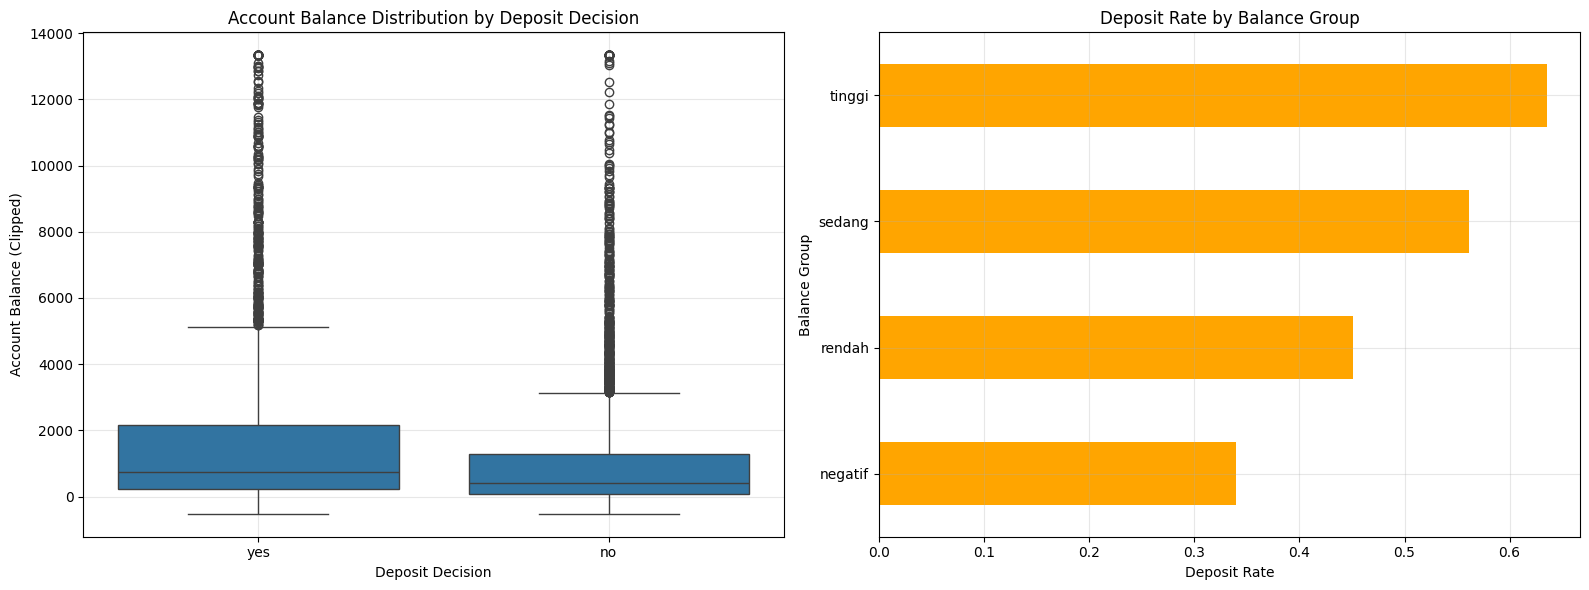

In [518]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create side-by-side visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Boxplot of balance distribution by deposit
sns.boxplot(x=df['deposit'], y=df['balance_clipped'], ax=axes[0])
axes[0].set_title('Account Balance Distribution by Deposit Decision')
axes[0].set_xlabel('Deposit Decision')
axes[0].set_ylabel('Account Balance (Clipped)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Bar chart of subscription rate by balance group
balance_group_counts = pd.crosstab(df['balance_group'], df['deposit'], normalize='index')
balance_group_counts['yes'].sort_values().plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Deposit Rate by Balance Group')
axes[1].set_xlabel('Deposit Rate')
axes[1].set_ylabel('Balance Group')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Age Dynamics

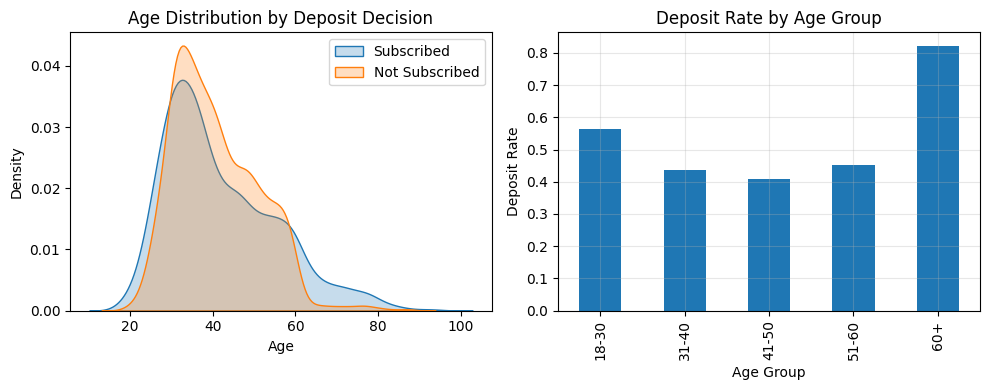

<Figure size 640x480 with 0 Axes>

In [519]:
# Age distribution analysis
plt.figure(figsize=(10, 4))

# Age distribution by deposit decision
plt.subplot(1, 2, 1)
sns.kdeplot(df[df['deposit'] == 'yes']['age'], label='Subscribed', shade=True)
sns.kdeplot(df[df['deposit'] == 'no']['age'], label='Not Subscribed', shade=True)
plt.title('Age Distribution by Deposit Decision')
plt.xlabel('Age')
plt.legend()

# Subscription rate by age group
plt.subplot(1, 2, 2)
# Create age bins
df['age_group'] = pd.cut(df['age'], bins=[18, 30, 40, 50, 60, 100], 
                         labels=['18-30', '31-40', '41-50', '51-60', '60+'])
age_subscription = pd.crosstab(df['age_group'], df['deposit'], normalize='index')
age_subscription['yes'].plot(kind='bar')
plt.title('Deposit Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Deposit Rate')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

## Campaign Contact Effectiveness

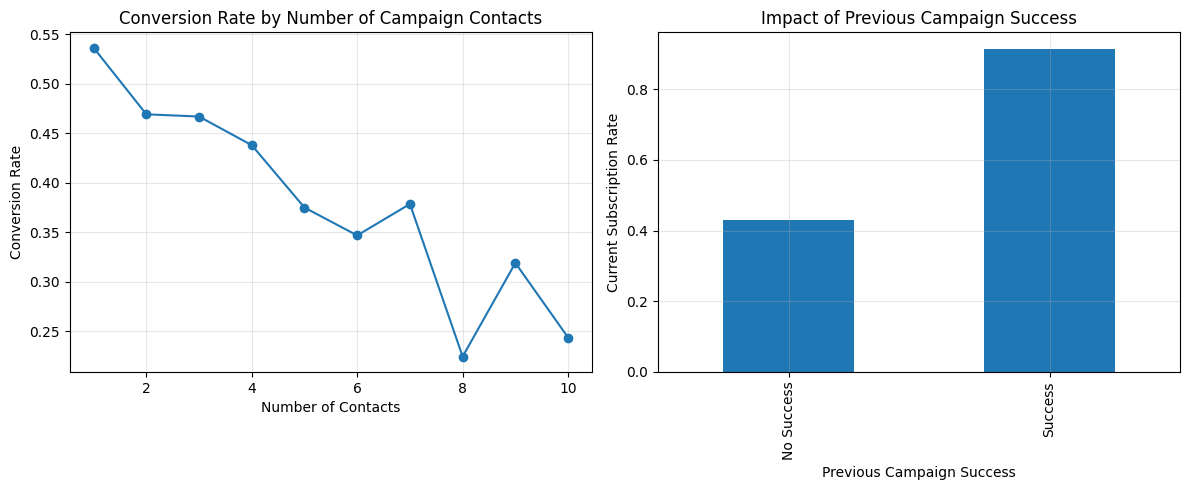

In [520]:
# Analyze campaign contacts
plt.figure(figsize=(12, 5))

# Conversion rate by number of contacts
plt.subplot(1, 2, 1)
campaign_conversion = df.groupby('campaign')['deposit'].apply(
    lambda x: (x == 'yes').mean()).reset_index()
campaign_conversion.columns = ['campaign', 'conversion_rate']
# Filter to contacts with sufficient data points
contact_counts = df['campaign'].value_counts()
sufficient_contacts = contact_counts[contact_counts > 30].index
campaign_conversion_filtered = campaign_conversion[
    campaign_conversion['campaign'].isin(sufficient_contacts)]

plt.plot(campaign_conversion_filtered['campaign'], 
         campaign_conversion_filtered['conversion_rate'], 'o-')
plt.title('Conversion Rate by Number of Campaign Contacts')
plt.xlabel('Number of Contacts')
plt.ylabel('Conversion Rate')
plt.grid(True, alpha=0.3)

# Previous success impact
plt.subplot(1, 2, 2)
previous_success_impact = pd.crosstab(df['previous_success'], df['deposit'], 
                                     normalize='index')['yes']
previous_success_impact.plot(kind='bar')
plt.title('Impact of Previous Campaign Success')
plt.xlabel('Previous Campaign Success')
plt.ylabel('Current Subscription Rate')
plt.xticks([0, 1], ['No Success', 'Success'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Contact Method Analysis

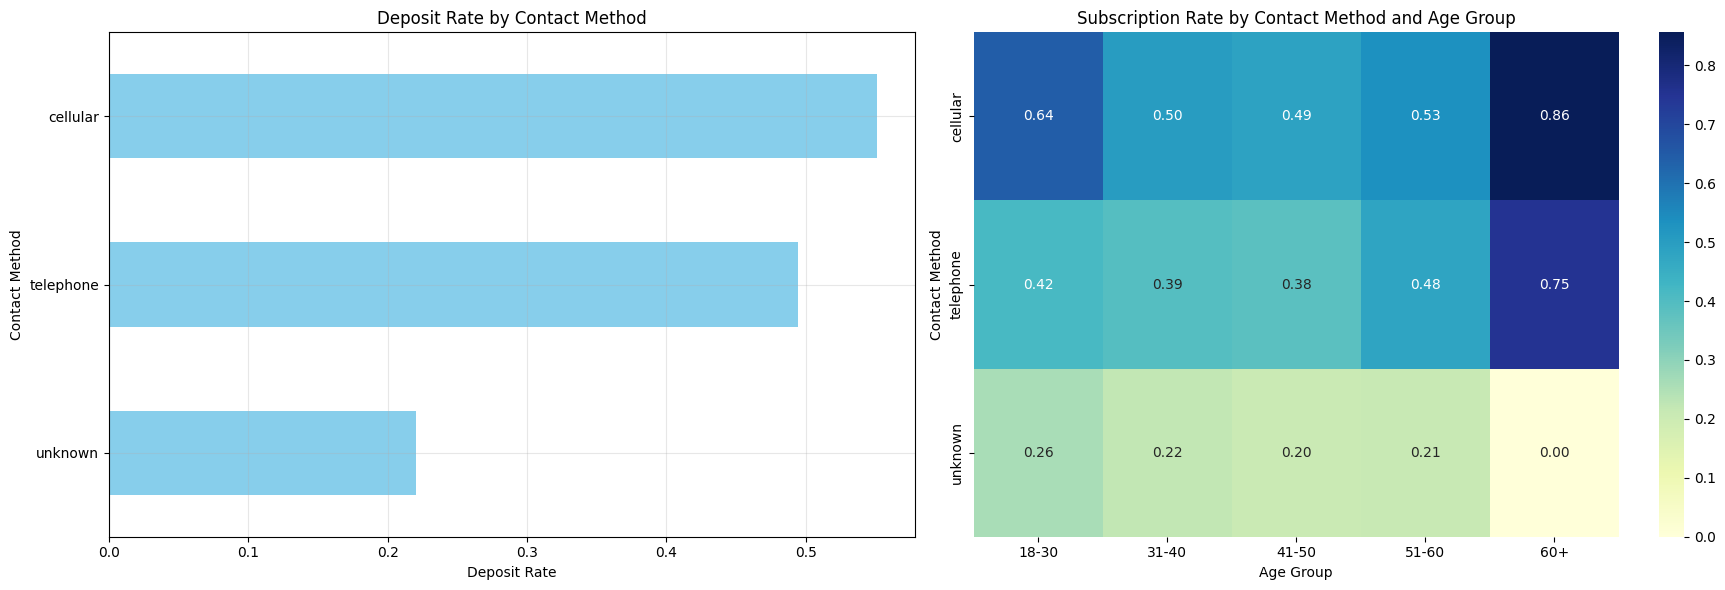

In [521]:
import matplotlib.pyplot as plt
import seaborn as sns

# Siapkan data
contact_success = pd.crosstab(df['contact'], df['deposit'], normalize='index')['yes']
contact_success = contact_success.sort_values()

contact_age_success = pd.crosstab(
    [df['contact'], df['age_group']], 
    df['deposit'], 
    normalize='index'
)['yes'].unstack()

# Buat visualisasi side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Bar horizontal - Deposit rate by contact method
contact_success.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Deposit Rate by Contact Method')
axes[0].set_xlabel('Deposit Rate')
axes[0].set_ylabel('Contact Method')
axes[0].grid(True, alpha=0.3)

# Plot 2: Heatmap - Interaction contact method vs age group
sns.heatmap(contact_age_success, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[1])
axes[1].set_title('Subscription Rate by Contact Method and Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Contact Method')

plt.tight_layout()
plt.show()


## Occupation and Financial Behavior

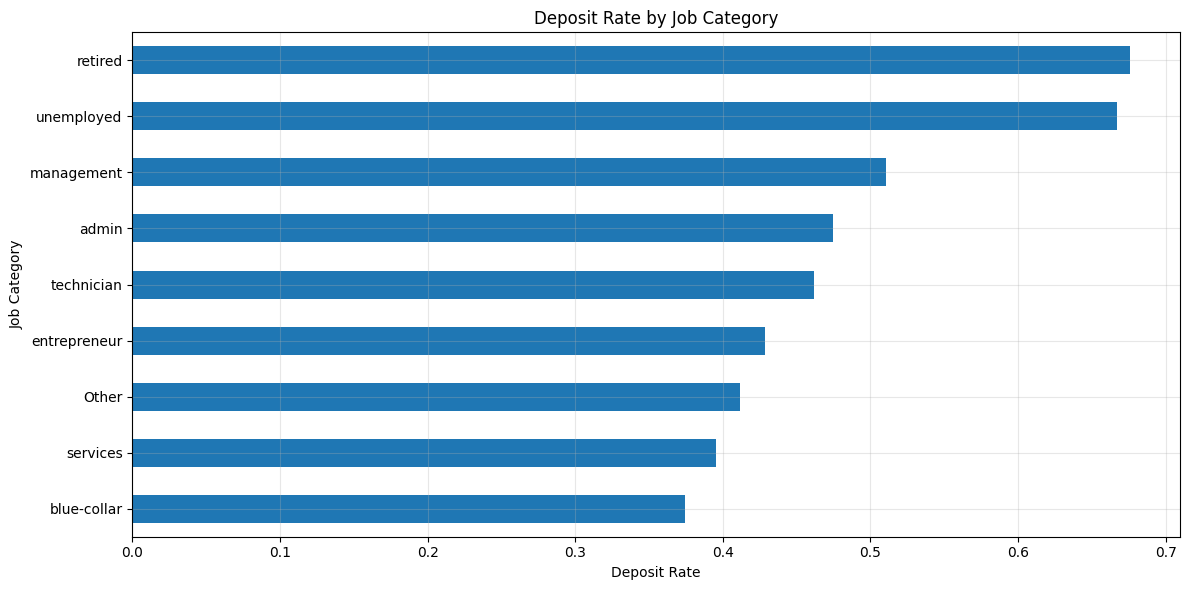

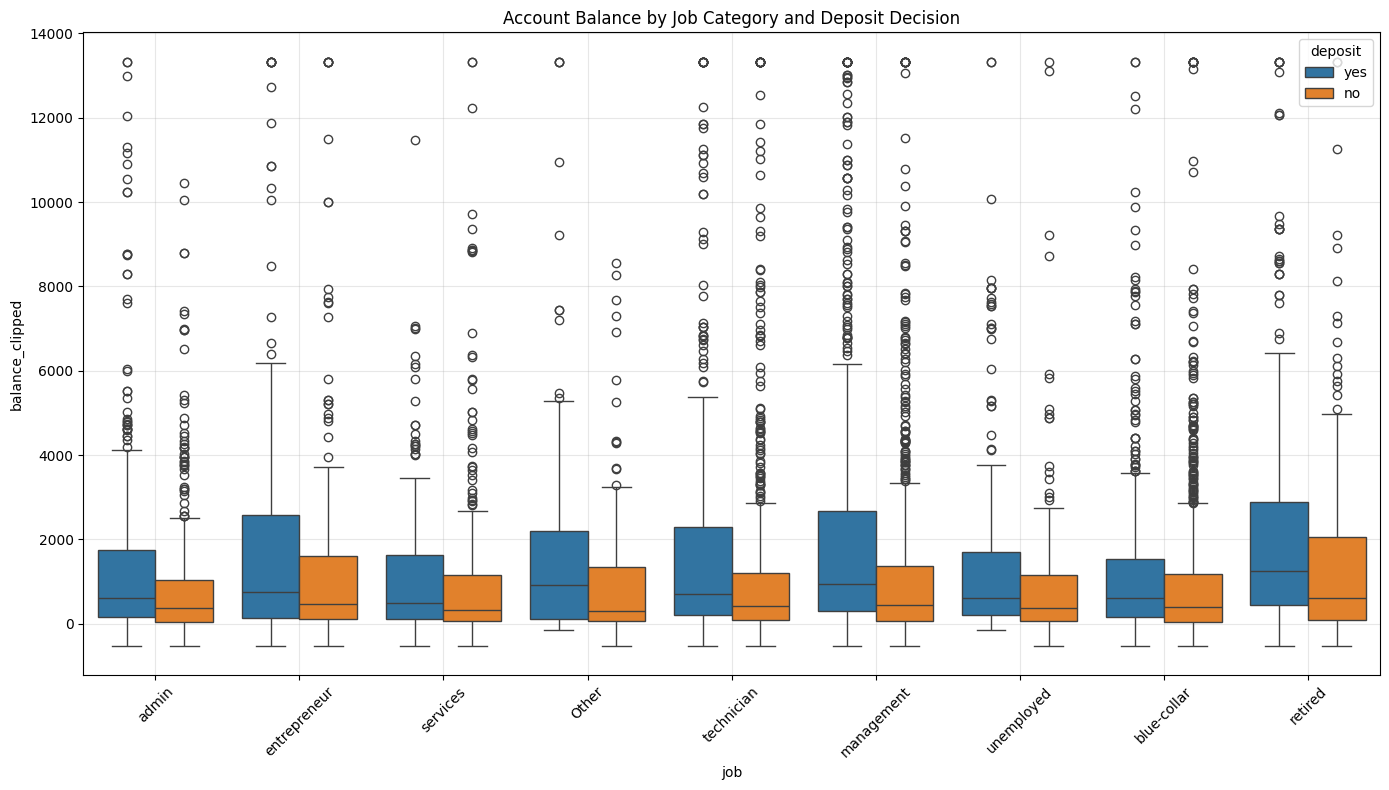

In [522]:
# Job category analysis
plt.figure(figsize=(12, 6))
job_success = pd.crosstab(df['job'], df['deposit'], normalize='index')['yes']
job_success.sort_values().plot(kind='barh')
plt.title('Deposit Rate by Job Category')
plt.xlabel('Deposit Rate')
plt.ylabel('Job Category')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Job & balance interaction
plt.figure(figsize=(14, 8))
sns.boxplot(x='job', y='balance_clipped', hue='deposit', data=df)
plt.title('Account Balance by Job Category and Deposit Decision')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Seasonal Patterns in Marketing Effectiveness


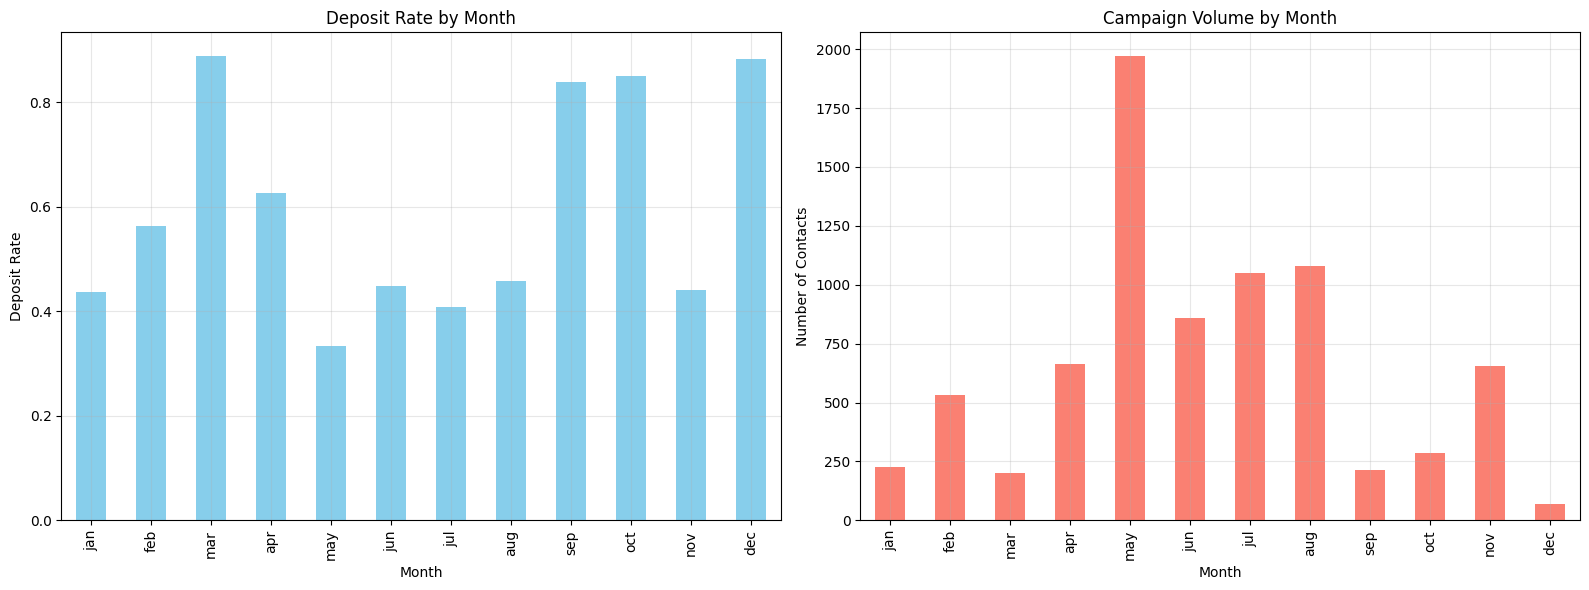

In [523]:
# Analyze monthly patterns side by side
import matplotlib.pyplot as plt

# Reorder months chronologically
months_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Prepare data
month_success = pd.crosstab(df['month'], df['deposit'], normalize='index')['yes']
month_success = month_success.reindex(months_order)

month_counts = df['month'].value_counts().reindex(months_order)

# Create side-by-side plots
plt.figure(figsize=(16, 6))

# Plot 1: Subscription rate
plt.subplot(1, 2, 1)
month_success.plot(kind='bar', color='skyblue', ax=plt.gca())
plt.title('Deposit Rate by Month')
plt.xlabel('Month')
plt.ylabel('Deposit Rate')
plt.grid(True, alpha=0.3)

# Plot 2: Campaign volume
plt.subplot(1, 2, 2)
month_counts.plot(kind='bar', color='salmon', ax=plt.gca())
plt.title('Campaign Volume by Month')
plt.xlabel('Month')
plt.ylabel('Number of Contacts')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
